In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from tqdm import tqdm
from quantum_logical.operators import selective_destroy
from scipy.optimize import curve_fit

In [2]:
# generating parameters and creating initial state
T1 = 80
T2 = 8
N = 5
dim = 3
trotter_dt = .02
amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_dt,
)


# qt.Qobj(amp_damp_channel._create_single_qubit_operators(T1=1)[1])
# identity = qt.qeye(dim ** N)

<p align="center"><img src="https://media.springernature.com/lw685/springer-static/image/chp%3A10.1007%2F978-1-4614-1800-9_152/MediaObjects/978-1-4614-1800-9_152_Fig3_HTML.gif">

<p align="center">Create the qutrit gates 

In [3]:
Hadamard = qt.Qobj([[1/np.sqrt(2), 1/np.sqrt(2), 0], [1/np.sqrt(2), -1/np.sqrt(2), 0], [0, 0, 1]])

mat_cnot1 = np.zeros(shape = (dim ** 2, dim ** 2))
for i in range(dim ** 2):
    for j in range(dim ** 2):
        if i == j and i != 6 and i != 8:
            mat_cnot1[i, j] = 1

mat_cnot1[6, 8] = mat_cnot1[8, 6] = 1
cnot1 = qt.Qobj(qt.tensor(qt.Qobj(mat_cnot1), qt.qeye(dim), qt.qeye(dim), qt.qeye(dim)).full())

mat_cnot2 = np.zeros(shape = (dim ** 3, dim ** 3))
for i in range(dim ** 3):
    for j in range(dim ** 3):
        if i == j and i != 18 and i != 20 and i != 21 and i != 23 and i != 24 and i !=26:
            mat_cnot2[i, j] = 1

mat_cnot2[18, 20] = mat_cnot2[20, 18] = mat_cnot2[21, 23] = mat_cnot2[23, 21] = mat_cnot2[24, 26] = mat_cnot2[26, 24] = 1
cnot2 = qt.Qobj(qt.tensor(qt.Qobj(mat_cnot2), qt.qeye(dim), qt.qeye(dim)).full())

mat_cnot3 = np.zeros(shape=(dim ** 4, dim ** 4))
for i in range(dim ** 4):
    for j in range(dim ** 4):
        if i == j and i not in [54, 56, 57, 59, 60, 62, 63, 65, 66, 68, 69, 71, 72, 74, 75, 77, 78, 80]:
            mat_cnot3[i, j] = 1

mat_cnot3[54, 56] = mat_cnot3[56, 54] = mat_cnot3[57, 59] = mat_cnot3[59, 57] = mat_cnot3[60, 62] = mat_cnot3[62, 60] = mat_cnot3[63, 65] = mat_cnot3[65, 63] = 1
mat_cnot3[66, 68] = mat_cnot3[68, 66] = mat_cnot3[69, 71] = mat_cnot3[71, 69] = mat_cnot3[72, 74] = mat_cnot3[74, 72] = mat_cnot3[75, 77] = mat_cnot3[77, 75] = mat_cnot3[78, 80] = mat_cnot3[80, 78] = 1

cnot3 = qt.Qobj(qt.tensor(qt.Qobj(mat_cnot3), qt.qeye(dim)).full())

cnot4 = qt.Qobj(qt.tensor(qt.qeye(dim), qt.Qobj(mat_cnot2), qt.qeye(dim)).full())

cnot5 = qt.Qobj(qt.tensor(qt.qeye(dim), qt.Qobj(mat_cnot3)).full())

cnot6 = qt.Qobj(qt.tensor(qt.qeye(dim),  qt.qeye(dim), qt.Qobj(mat_cnot2)).full())

# creating the x-gates
x_gate = qt.Qobj([[0, 0, 1], [0, 1, 0],[1, 0, 0]])

z_gate = qt.Qobj([[1, 0, 0], [0, 1, 0], [0, 0, -1]])

Build the initial encoded state 

In [4]:
psi0 = qt.tensor((qt.basis(dim, 0) + qt.basis(dim, 2)).unit(), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0), qt.basis(dim, 0))
rho0 = psi0 * psi0.dag()

In [5]:
# creating the initial hadamard gates 
hada_list = qt.Qobj(qt.tensor(Hadamard, Hadamard, Hadamard, qt.qeye(dim), qt.qeye(dim)).full())

In [6]:
# applying the initial state 
rho_pre_hada = cnot2.dag() * cnot1.dag() * qt.Qobj(rho0.full()) * cnot1 * cnot2
rho_post_hada = hada_list.dag() * rho_pre_hada * hada_list

In [7]:
# applying the error channel

states = [] # list of states 

error_state = trotter.apply(rho_post_hada, duration=100, discrete_unitary=qt.qeye(dim ** N))
states.extend(error_state)


In [8]:
hada_after_error = hada_list.dag() * error_state[-1] * hada_list
states.append(hada_after_error)

# need to apply the x_gates before you get to the next step otherwise this will not work 
x_gate_list1 = qt.Qobj(qt.tensor(x_gate, x_gate, qt.qeye(dim), qt.qeye(dim), qt.qeye(dim)).full())
x_gate_list2 = qt.Qobj(qt.tensor(qt.qeye(dim), x_gate, x_gate, qt.qeye(dim), qt.qeye(dim)).full())
gates_pre_measure1 = x_gate_list1 * cnot4 * cnot3 * x_gate_list1
gates_pre_measure2 = x_gate_list2 * cnot6 * cnot5 * x_gate_list2

In [9]:
# state pre measure but before applying the last set of hadamards
pre_measure_state = trotter.apply(hada_after_error, duration=40, discrete_unitary=gates_pre_measure1)
states.extend(pre_measure_state)
pre_measure_state2 = trotter.apply(pre_measure_state[-1], duration=40, discrete_unitary=gates_pre_measure2)
states.extend(pre_measure_state2)

In [10]:
pre_measure_hada = hada_list.dag() * pre_measure_state2[-1] * hada_list
states.append(pre_measure_hada)
final_state = pre_measure_hada

<p align="center">Measurement projectors:

In [11]:
projection_op = [qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 0))).dag()))).full()),
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 0))).dag()))).full()), 
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 0), qt.basis(dim, 1))).dag()))).full()),
                qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), qt.qeye(dim), (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1)) * (qt.tensor(qt.basis(dim, 1), qt.basis(dim, 1))).dag()))).full())
]

In [12]:
# rho_new = projection_op[0].dag() * final_state * projection_op[0] + projection_op[1].dag() * final_state * projection_op[1] + projection_op[2].dag() * final_state * projection_op[2] + projection_op[3].dag() * final_state * projection_op[3]
rho_1 = qt.tensor(qt.qeye(dim ** N)).dag() * projection_op[0].dag() * final_state * projection_op[0] * qt.tensor(qt.qeye(dim ** N))
rho_2 = qt.Qobj((qt.tensor(z_gate, qt.qeye(dim ** 4)).dag()).full()) * projection_op[1].dag() * final_state * projection_op[1] * qt.Qobj((qt.tensor(z_gate, qt.qeye(dim ** 4))).full())
rho_3 = qt.Qobj((qt.tensor(qt.qeye(dim), z_gate, qt.qeye(dim ** 3)).dag()).full()) * projection_op[2].dag() * final_state * projection_op[2] * qt.Qobj((qt.tensor(qt.qeye(dim), z_gate, qt.qeye(dim ** 3))).full())
rho_4 = qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), z_gate, qt.qeye(dim ** 2)).dag()).full()) * projection_op[3].dag() * final_state * projection_op[3] * qt.Qobj((qt.tensor(qt.qeye(dim), qt.qeye(dim), z_gate, qt.qeye(dim ** 2))).full())
rho_new = rho_1 + rho_2 + rho_3 + rho_4
# rho_new = rho_1
states.append(rho_new)

In [13]:
# add a relaxation period to see what it looks like 
relaxation = trotter.apply(rho_new, duration=800, discrete_unitary=qt.qeye(dim ** N))
states.extend(relaxation)

In [14]:
time_list = np.linspace(0, 1040, len(states))

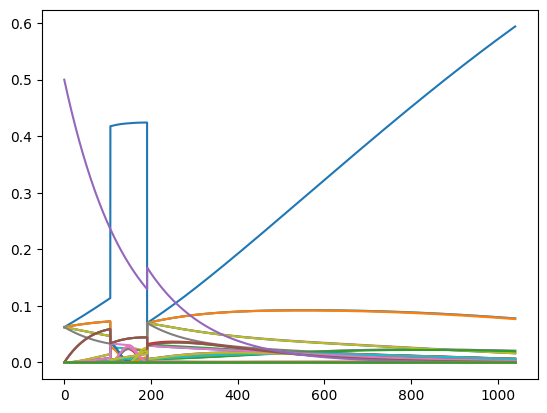

In [15]:
# label these plots with the states
fig, ax = plt.subplots()
for i in range(dim ** N):
    datas = []
    for j in range(len(states)):
        # print(np.real(states[j][i, i]))
        datas.append(np.real(states[j][i][i]))    
    ax.plot(time_list, datas)